In [22]:
import pandas as pd
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Leitos_2024.csv", encoding = "latin1")

In [3]:
df.columns

Index(['COMP', 'REGIAO', 'UF', 'MUNICIPIO', 'MOTIVO_DESABILITACAO', 'CNES',
       'NOME_ESTABELECIMENTO', 'RAZAO_SOCIAL', 'TP_GESTAO', 'CO_TIPO_UNIDADE',
       'DS_TIPO_UNIDADE', 'NATUREZA_JURIDICA', 'DESC_NATUREZA_JURIDICA',
       'NO_LOGRADOURO', 'NU_ENDERECO', 'NO_COMPLEMENTO', 'NO_BAIRRO', 'CO_CEP',
       'NU_TELEFONE', 'NO_EMAIL', 'LEITOS_EXISTENTES', 'LEITOS_SUS',
       'UTI_TOTAL_EXIST', 'UTI_TOTAL_SUS', 'UTI_ADULTO_EXIST',
       'UTI_ADULTO_SUS', 'UTI_PEDIATRICO_EXIST', 'UTI_PEDIATRICO_SUS',
       'UTI_NEONATAL_EXIST', 'UTI_NEONATAL_SUS', 'UTI_QUEIMADO_EXIST',
       'UTI_QUEIMADO_SUS', 'UTI_CORONARIANA_EXIST', 'UTI_CORONARIANA_SUS'],
      dtype='object')

In [4]:
df = df[["UF","MUNICIPIO","CNES","NOME_ESTABELECIMENTO","LEITOS_EXISTENTES"]]
df

UF                MUNICIPIO     CNES  \
0      PE  CABO DE SANTO AGOSTINHO       27   
1      PE  CABO DE SANTO AGOSTINHO       35   
2      PE  CABO DE SANTO AGOSTINHO       94   
3      PE  CABO DE SANTO AGOSTINHO      183   
4      PE  CABO DE SANTO AGOSTINHO      221   
...    ..                      ...      ...   
28243  PE                 IGARASSU  9968830   
28244  SP      SAO JOSE DOS CAMPOS  9989757   
28245  SP                  ITAPEVI  9997032   
28246  PB                    CONDE  9997172   
28247  MA                BACABEIRA  9997784   

                                    NOME_ESTABELECIMENTO  LEITOS_EXISTENTES  
0                             CASA DE SAUDE SANTA HELENA                 64  
1                                 HOSPITAL MENDO SAMPAIO                 19  
2                 MATERNIDADE PADRE GERALDO LEITE BASTOS                 18  
3                                    HOSPITAL SAMARITANO                 59  
4                                 HOSPITAL SAO SEBASTIAO                 47  
...                                                  ...                ...  
28243                           GRUPO RECANTO UNIDADE II                 40  
28244  HOSPITAL OFTALMOLOGICO DE SAO JOSE DOS CAMPOS ...                 15  
28245                                       HOSPITAL YES                120  
28246                        CLINICA MEDICA PERSONNALITE                 40  
28247               HOSPITAL E MATERNIDADE NAILA GONCALO                 26  

[28248 rows x 5 columns]

In [5]:
df_agup_cidade = df[["MUNICIPIO","LEITOS_EXISTENTES"]].groupby("MUNICIPIO").sum().reset_index()
df_agup_cidade

MUNICIPIO  LEITOS_EXISTENTES
0     ABADIA DOS DOURADOS                 48
1               ABADIANIA                 36
2                  ABAETE                184
3              ABAETETUBA               1224
4                  ABAIRA                 40
...                   ...                ...
3383                XAXIM                128
3384                XEXEU                 56
3385             XINGUARA                506
3386          XIQUE-XIQUE                372
3387              ZE DOCA                200

[3388 rows x 2 columns]

In [1]:
# Geocodificar os municípios
geolocator = Nominatim(user_agent="geoapiExercises")

def geocode(municipio):
    """
    Essa função obtém a latitude e longitude de cada município do Brasil.
    """

    try:
        location = geolocator.geocode(f"{municipio}, Brasil")
        return location.latitude, location.longitude
    except:
        return pd.NA, pd.NA
    
# Inicializaçãpo dos atributos de localização
df_agup_cidade["LATITUDE"] = 0
df_agup_cidade["LONGITUDE"] = 0

# Atribuição de Latitude e Longitude
for i in range(df_agup_cidade.shape[0]):
    df_agup_cidade["LATITUDE"][i], df_agup_cidade["LONGITUDE"][i] = geocode(df_agup_cidade["MUNICIPIO"][i])

In [10]:
df_agup_cidade.dropna(subset=["LATITUDE", "LONGITUDE"])

MUNICIPIO  LEITOS_EXISTENTES   LATITUDE  LONGITUDE
6     ABEL FIGUEIREDO                 88  -4.953001 -48.395848
7        ABELARDO LUZ                168 -26.570589 -52.328034
8          ABRE CAMPO                276 -20.295421 -42.480131
9        ABREU E LIMA                292  -7.900719 -34.898389
10         ACAILANDIA                952  -4.951503 -47.500732
...               ...                ...        ...        ...
3383            XAXIM                128 -26.960536 -52.533550
3384            XEXEU                 56  -8.803674 -35.624444
3385         XINGUARA                506  -7.099851 -49.941663
3386      XIQUE-XIQUE                372 -10.821719 -42.726569
3387          ZE DOCA                200  -3.270145 -45.655344

[3323 rows x 4 columns]

In [14]:
# Salvamento do csv obtido anteriormente

df_agup_cidade.to_csv("df_leitos_br.csv", index=False)

In [8]:
# Gráfico Mapa

# Intervalos e as cores correspondentes
intervalos = [0, 50, 100, 200, 500, 1000, 2000, 5000, 7000, 10000, float("inf")]
cores = ["#FFFFB2", "#FED976", "#FEB24C", "#FD8D3C", "#FC4E2A", "#E31A1C", "#BD0026", "#800026", "#660000", "#4B0000"]

# Colunas de classe/cor 
df_agup_cidade["classe"] = pd.cut(df_agup_cidade["LEITOS_EXISTENTES"], bins=intervalos, labels=range(1, 11), right=False)
df_agup_cidade["cor"] = df_agup_cidade["classe"].apply(lambda x: cores[int(x)-1])

# Localização inicial da visuzalização
latitude_media = df_agup_cidade["LATITUDE"].mean()
longitude_media = df_agup_cidade["LONGITUDE"].mean()
mapa = folium.Map(location=[latitude_media, longitude_media], zoom_start=5)

#  Adição de municípios ao mapa
for _, row in df_agup_cidade.iterrows():
    folium.CircleMarker(
        location=(row["LATITUDE"], row["LONGITUDE"]),
        radius=1.5,  
        popup=folium.Popup(f'{row["MUNICIPIO"]}: {row["LEITOS_EXISTENTES"]} leitos', parse_html=True),
        color=row["cor"],
        fill=True,
        fill_color=row["cor"],
        fill_opacity=0.7  
    ).add_to(mapa)

# Legenda do mapa
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 300px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius:5px;">
     &nbsp; <b>Quantidade de Leitos</b> <br>
     &nbsp; 0 - 50: <i style="background:#FFFFB2; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 50 - 100: <i style="background:#FED976; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 100 - 200: <i style="background:#FEB24C; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 200 - 500: <i style="background:#FD8D3C; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 500 - 1000: <i style="background:#FC4E2A; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 1000 - 2000: <i style="background:#E31A1C; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 2000 - 5000: <i style="background:#BD0026; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 5000 - 7000: <i style="background:#800026; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 7000 - 10000: <i style="background:#660000; width:20px;height:10px;display:inline-block;"></i> <br>
     &nbsp; 10000+: <i style="background:#4B0000; width:20px;height:10px;display:inline-block;"></i> <br>
</div>
"""

mapa.get_root().html.add_child(folium.Element(legend_html))

mapa.save("mapa_leitos_existentes.html")

mapa

In [20]:
populacaoIdosa = pd.read_csv("populacaoIdosa.CSV", sep=";")
populacaoIdosa.head()

Territorialidades  Taxa de envelhecimento 2021  \
0            Brasil                        10.15   
1              Acre                         5.66   
2           Alagoas                         7.79   
3             Amapá                         5.24   
4          Amazonas                         6.03   

   População de 65 anos ou mais de idade 2021  População total 2021  
0                                    21590309             212650323  
1                                       50321                889829  
2                                      261596               3358030  
3                                       45496                869050  
4                                      247574               4103520

In [16]:
# Dropando dado do Brasil

populacaoIdosa = populacaoIdosa[:][1:]

In [30]:
populacaoIdosa = populacaoIdosa.sort_values("Taxa de envelhecimento 2021", ascending=False)[:10]
populacaoIdosa

Territorialidades  Taxa de envelhecimento 2021  \
19     Rio de Janeiro                        13.47   
21  Rio Grande do Sul                        12.85   
25          São Paulo                        11.40   
5               Bahia                        10.91   
13       Minas Gerais                        10.50   
0              Brasil                        10.15   
24     Santa Catarina                        10.07   
15             Paraná                         9.80   
6               Ceará                         9.67   
18              Piauí                         9.57   

    População de 65 anos ou mais de idade 2021  População total 2021  
19                                     2353017              17462801  
21                                     1470783              11448117  
25                                     5316726              46642575  
5                                      1632460              14965636  
13                                     2247854              21401130  
0                                     21590309             212650323  
24                                      737545               7326578  
15                                     1134692              11584089  
6                                       893736               9237820  
18                                      314844               3288504

Text(0, 0.5, '')

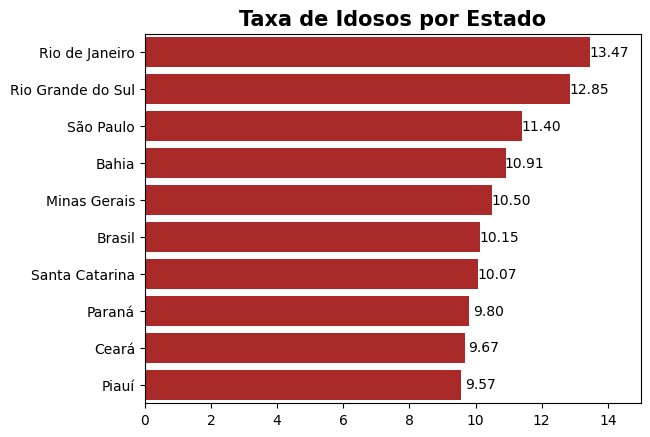

In [53]:
# Gráfico Idosos

ax = sns.barplot(x=populacaoIdosa["Taxa de envelhecimento 2021"],y=populacaoIdosa["Territorialidades"], estimator="sum", color="#BF1515")

# Adiciona rótulos nas barras
for p in ax.patches:
    width = p.get_width()  
    plt.text(width + 0.58,  
             p.get_y() + p.get_height() / 2,  
             f"{width:.2f}",  
             ha="center", va="center")  
plt.title("Taxa de Idosos por Estado", weight="bold", size=15)
plt.xlim(0,15)
plt.xlabel(None)
plt.ylabel(None)